## This is the second introductory example for the pyioflash library

First we need to import the necessary python modules for this example and set matplotlib to inline for the notebook

In [1]:
from sys import stdout
import numpy
from matplotlib import pyplot, colorbar, cm, colors, animation
from IPython.display import HTML

We need to import the necessary packages from the pyioflash library.

In this case we will need the main data analysis package and some packeges out of the post-processing part of the library which provides the basic utilites necessary to manipulate the simulation output data

In [2]:
from pyioflash import SimulationData, sources, elements, analyses

Again we are going to read in the simulation data into a management object

In [3]:
data = SimulationData.from_list(range(61), path='data/', basename='INS_Rayleigh_', header='hdf5_plt_cnt_')


############    Building SImulationData Object   ############

Processing metadata from: data/INS_Rayleigh_hdf5_plt_cnt_0000
Reading Grid from File
Processing file: data/INS_Rayleigh_hdf5_plt_cnt_0060

#############################################################




Let's make a plot of some meaningful quantity from the data at hand, the mean kinetic energy from 40 to 60 simulation seconds for example.

We will need to use the energy module out of the sources package that we imported; in this case:
    
    energy.kinetic_mean(data, start=40.0, stop=xx, withguard=True, keepdims=False)
    
This function takes a SimulationData object and returns the mean kinetic energy over a time range. We should briefly discuss two of the options provided; namely, withguard and keepdims. We want to tell the function that we want to return the desired result with guard cells attached so that we can do the plotting operation; we saw that this was needed in the last notebook. Secondly, we need to tell the function that we do not want to keep the z-axis dimension in the data to simplify our plotting.

There is one issue in the result that is returned; while the result is provided with guard cells, the lower guard cells for the staggered axis (e.g., x axis for u velocity) are not filled in with the correct guarding data but rather are initialized to zero. This is a result of the face-centered staggered grid fields having the same number of saved points as the cell-centered fields when we interpolate to the cell centers. Specifically, there is not an additional lowermost cell in the staggered direction to compute an equivalent cell-centered guard value for the result. However, long story short, we can deal with this by simply plotting the blocks in a reveresed order. We only needed those guard cells to prevent gaps in the plotted result, and if the upper guard cells are filled in, we will just plot in reverse order so that the result is layered as desired.

In order to plot the blocks in reverse order we would only have to wrap the arrays with 'reversed()':

    for x, y, z in zip(reversed(xx), reversed(yy), reversed(KE)):
    
However, that is duplicative to write-out, instead lets make a tuple and unpack it into 'zip()' as follows:

    *(reversed(field) for field in (xx, yy, KE))

Lets try this now.

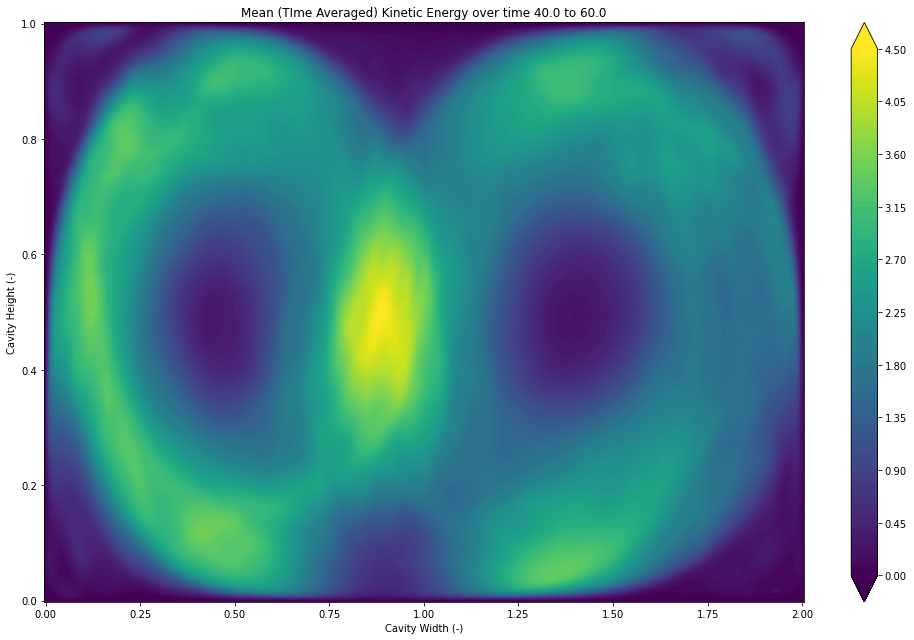

In [4]:
# Let's import the needed grid and field data from our simulation object
times, = data.scalars['t']
xx, yy = data.geometry._grd_mesh_x[1, :, 1, :, :], data.geometry._grd_mesh_y[1, :, 1, :, :]
KE = sources.energy.kinetic_mean(data, start=40.0, stop=60.0, withguard=True, keepdims=False)

# Let's set some limits and color information
fmin, fmax = numpy.min(KE), numpy.max(KE)
lvls = numpy.linspace(round(fmin), round(fmax, 1), 81)
cmap = cm.viridis
norm = colors.Normalize(vmin=fmin, vmax=fmax)

# Now let's plot the contour and quiver one block at a time
fig, ax = pyplot.subplots(figsize=(14, 9))
for x, y, z in zip(*(reversed(field) for field in (xx, yy, KE))):
    cax = ax.contourf(x, y, z, lvls, vmin=fmin, vmax=fmax, norm=norm, cmap=cmap, extend='both')

# lets add some labeling to the plot
fig.colorbar(cax, ax=ax, ticks=lvls[::8])
ax.set_title('Mean (TIme Averaged) Kinetic Energy over time 40.0 to 60.0')
ax.set_xlabel('Cavity Width (-)')
ax.set_ylabel('Cavity Height (-)')
fig.tight_layout();

Let's have a closer look at the documentation provided for the kinetic_mean function

    Provides a method for calculation of the mean or time-averaged kinetic energy by 
    consuming a SimulationData object and a time interval specification; 
    must have 'fcx2', 'fcy2' ('fcz2' if 3d) attributes in the SimulationData.fields object.
    
    Attributes:
        data: object containing relavent flash simulation output
        steps: iterable time-like specification for which to process data, the keys (optional) 
        start: used to determine the starting time-like specification, start key (optional)
        stop: used to determine the ending time-like specification, stop key (optional)
        skip: used to determine the sampling interval for the specification (optional)
        wrapped: whether to wrap context around result of sourcing (optional)
        mapping: if wrapped, how to map context to options of the next operation (optional)
        scale: used to convert returned quantity to dimensional units (optional)
        index: used for custom slicing operation; should be (blks, k, j, i) (optional)
        withguard: retain guard cell data for ploting and other actions (optional)
        keepdims: retain unused dimensions for broadcasting, else drop them (optional)
        
    Note:
        The mean kinetic energy is computed according to the formula
                E(t)~ijk~ = $\sum_{$\tau$=t~0~}^{t} (u($\tau$)~ijk~^2^ + v($\tau)~ijk~^2^ + w($tau$)~ijk~^2^) / N
                
                *where the all terms are interpolated to cell centers*
        This function does not generate any dynamic context; this even if wrapping is desired and specified, the
        mapping attribute is ignored.

Now let's plot the turbulent kinetic energy with another function provided in the energy module.

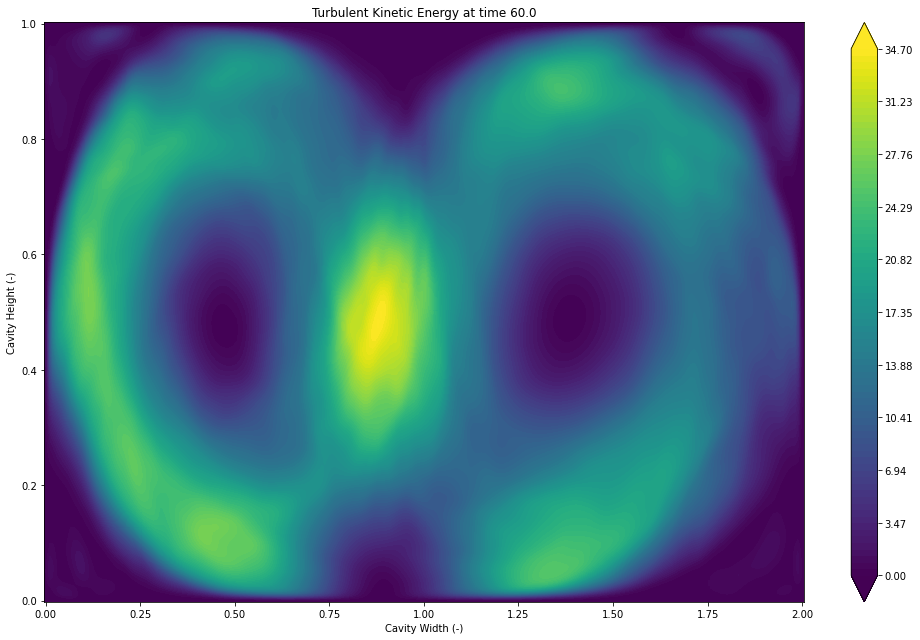

In [5]:
# Let's import the needed grid and field data from our simulation object
times, = data.scalars['t']
xx, yy = data.geometry._grd_mesh_x[1, :, 1, :, :], data.geometry._grd_mesh_y[1, :, 1, :, :]
TE = sources.energy.kinetic_turbulant(data, 60.0, start=40.0, stop=60.0, withguard=True, keepdims=False)

# Let's set some limits and color information
fmin, fmax = numpy.min(TE), numpy.max(TE)
lvls = numpy.linspace(round(fmin, 1), round(fmax, 1), 81)
cmap = cm.viridis
norm = colors.Normalize(vmin=fmin, vmax=fmax)

# Now let's plot the contour and quiver one block at a time
fig, ax = pyplot.subplots(figsize=(14, 9))
for x, y, z in zip(reversed(xx), reversed(yy),  reversed(TE)):
    cax = ax.contourf(x, y, z, lvls, vmin=fmin, vmax=fmax, norm=norm, cmap=cmap, extend='both')

# lets add some labeling to the plot
fig.colorbar(cax, ax=ax, ticks=lvls[::8])
ax.set_title('Turbulent Kinetic Energy at time 60.0')
ax.set_xlabel('Cavity Width (-)')
ax.set_ylabel('Cavity Height (-)')
fig.tight_layout();

If we want to make a movie out of the turbulant kinetic energy we could do something like this:

    TE_time = [sources.energy.kinetic_turbulent(data, step, mean=mean, withguard=True, keepdims=False) 
               for step in range(61)]
               
Instead let's have look at another package that we imported, the analyses package. Because what we want to do is essentially the most trivial example of a time-series analysis we can use this package to give us what we want.

The series module in the analyses package provides a time-series analysis method that will serve our purpose, simple. Let's see how to use it.

    result = series.simple(source, sourceby, stack)
    
As we can see simple first and formost consumes a source object and a set of items used to source the information. Secondly, ant this is what makes this method useful, it takes a set of elements (i.e., the stack) and applies each in turn to the data obtained from the source. In this way, we can easily abstract the idea of obtaining the time and space averaged thermal energy from the simulation output. More on this in the next notebook, but for now lets see how to source information and lets disreguard the stack for now.

There are a number of ways to provided a suitable source to the simple method, lets look at one of the most powerful means. We are going to use a helper method provided in the analyses package, make_sourceable, to turn one of the methods provided in the sources package, kinetic_turbulant, into a usable source for the simple method.

    make_sourceable(source, args=..., method='{Sourceby Method}', options={'option': value, ...})
    
Now there is a lot to unpack here ... that was a joke ... ok, a bad one but can you blame me.

We are going to use this as follows:

    source = analyses.make_sourceable(sources.energy.kinetic_turbulant, data, method='step', 
                                      options={'mean': mean, 'withguard': True, 'keepdims': False})
                                      
Remember we have used the kinetic_turbulent method previously with the following:

    sources.energy.kinetic_turbulant(data, 60.0, mean=mean, withguard=True, keepdims=False)
    
Let's breakdown the arguments one at a time:

    1) source.energy.kinetic_turbulant -- the intended sourcing method
    
    2) data -- the only args we need to provide is data as when the simple method is called with
               this source it will repeatedly provide the last positional argument to the source function (i.e, the step)
               
    3) method='step' -- this argument is not important now, it just tells the helper method that we are going to be sourcing
                        by steps (e.g., [0, 1, 2, ... 60]) vice some more ellaborate method
                        
    4) options={...} -- here we are providing the keyword arguments we previously used in the last example
    
    
Now let's try this out

In [6]:
mean = sources.fields.velocity_mean(data, start=40.0, stop=60.0, withguard=True)
source = analyses.make_sourceable(sources.energy.kinetic_turbulant, data, method='step', 
                                  options={'mean': mean, 'withguard': True, 'keepdims': False})
TE_time = analyses.series.simple(source=source, sourceby=range(61))

Let's make a simple animation of the data as we did in the last notebook.

In [7]:
%%capture

# Let's import the necessary field data
times, = data.scalars['t']
xx, yy = data.geometry._grd_mesh_x[1, :, 1, :, :], data.geometry._grd_mesh_y[1, :, 1, :, :]

# Let's set some limits and color information
fmin, fmax = numpy.min(TE_time), numpy.max(TE_time)
lvls = numpy.linspace(round(fmin, 1), round(fmax, 1), 81)
cmap = cm.viridis
norm = colors.Normalize(vmin=fmin, vmax=fmax)

# Make figure and axis
fig, ax = pyplot.subplots(figsize=(14, 9))
ax.set(xlim=(0.0, 2.0), ylim=(0.0, 1.0))

# Initialize the first frame and plot objects
cax = {}
for b, (x, y, z) in enumerate(zip(*(reversed(field) for field in (xx, yy, TE_time[0, :, :, :])))):
    cax[b] = ax.pcolormesh(x, y, z, vmin=fmin, vmax=fmax, norm=norm, cmap=cmap, 
                          antialiased=False, shading='gouraud')
fig.colorbar(cax[0], ax=ax)
ax.set_xlabel('Cavity Width (-)')
ax.set_ylabel('Cavity Height (-)')


# Make a animate frame function
def animate(step):
    for b, z in enumerate(reversed(TE_time[step, :, :, :])):
        stdout.write("Processing animation at step %d \r" % (step))
        stdout.flush()

        cax[b].set_array(z.ravel())
        ax.set_title('Temperature Field at time = %5.2f' % (times[step]))

# Finaly, create the animation object
anim = animation.FuncAnimation(fig, animate, frames=range(61), interval=300, blit=False)

In [8]:
# Let's view the animation
HTML(anim.to_html5_video())

That's an iteresting result.

Let's look at how the turbulent kinetic energy is distributed by making a histogram

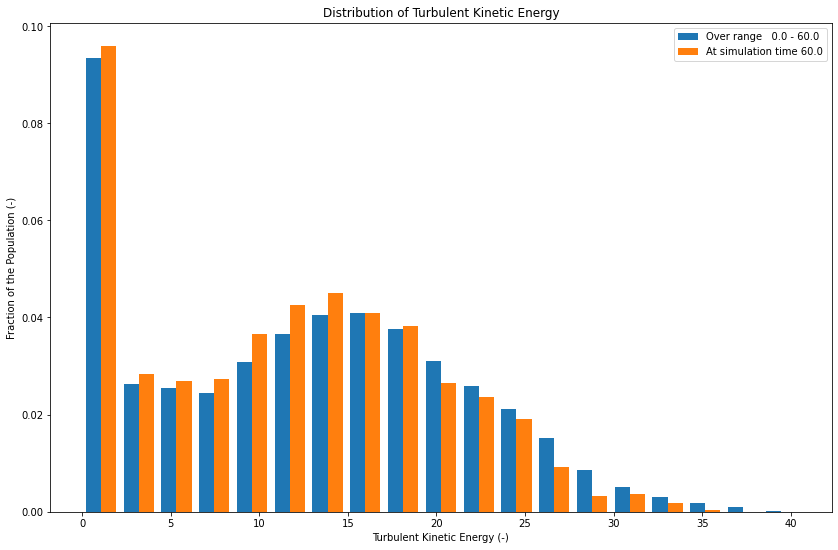

In [9]:
# How many bins do we want and over what range
fmin, fmax = numpy.min(TE_time), numpy.max(TE_time)
lvls = numpy.linspace(round(fmin, 1), round(fmax, 1), 20)
hist = [item.ravel() for item in (TE_time, TE_time[-1])]
lbls = ['Over range   0.0 - 60.0', 
        'At simulation time 60.0']

# Make figure and axis
fig, ax = pyplot.subplots(figsize=(14, 9))
ax.hist(hist, lvls, density=True, rwidth=0.8, label=lbls, cumulative=False)
ax.legend(prop={'size': 10})
ax.set_xlabel('Turbulent Kinetic Energy (-)')
ax.set_ylabel('Fraction of the Population (-)')
ax.set_title('Distribution of Turbulent Kinetic Energy');

To conclude this notebook, let's use the above information to look at just the most probable range of turbulant kinetic energies at time 60.0 along with a quiver plot of velocity data.

In other words where is the turbulance located in the cell.

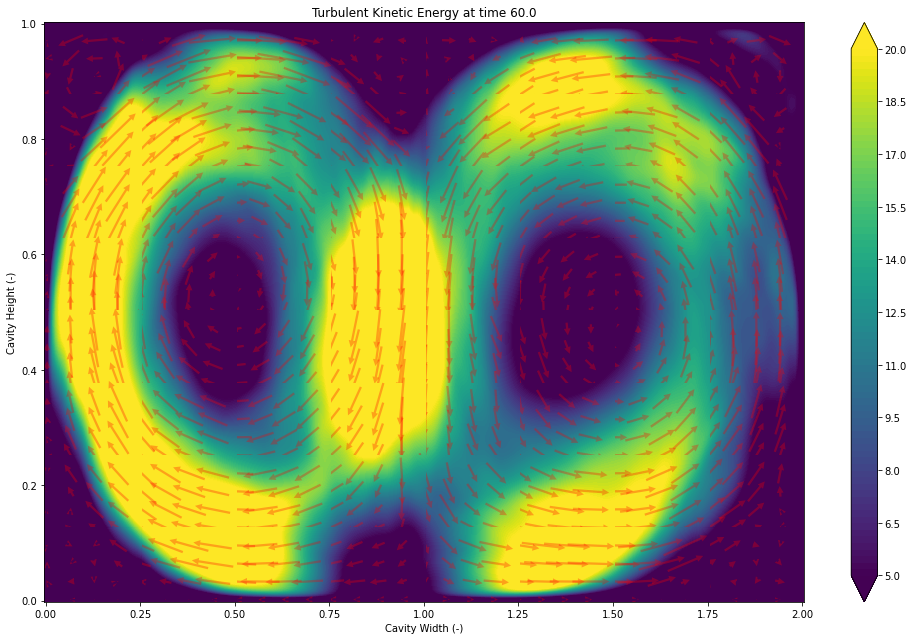

In [10]:
# Let's import the needed grid and field data from our simulation object
times, = data.scalars['t']
xx, yy = data.geometry._grd_mesh_x[1, :, 1, :, :], data.geometry._grd_mesh_y[1, :, 1, :, :]
u, v, T = data.fields['_fcx2', '_fcy2', '_temp'][-1, :, 1, :, :]
TE = sources.energy.kinetic_turbulant(data, 60.0, mean=mean, withguard=True, keepdims=False)

# Let's move the face data to the cell centers
u = (u[:, 1:-1, 1:-1] + u[:, :-2, 1:-1]) / 2
v = (v[:, 1:-1, 1:-1] + v[:, 1:-1, :-2]) / 2

# Let's set some limits and color information
fmin, fmax = 5, 20
lvls = numpy.linspace(round(fmin, 1), round(fmax, 1), 81)
cmap = cm.viridis
norm = colors.Normalize(vmin=fmin, vmax=fmax)

# Let's set some options to make the quiver look nice
skp = 8
options = {'pivot': 'middle', 'minshaft': 0.2, 'minlength': 0.3, 
           'headlength': 3, 'headaxislength': 3, 'headwidth': 3, 
           'scale': 8, 'alpha': 0.3, 'width': 0.003, 'linestyle': 'solid', 'color': 'red'}

# Now let's plot the contour and quiver one block at a time
fig, ax = pyplot.subplots(figsize=(14, 9))
for x, y, i, j, z in zip(*(reversed(field) for field in (xx, yy, u, v, TE))):
    cax = ax.contourf(x, y, z, lvls, vmin=fmin, vmax=fmax, norm=norm, cmap=cmap, extend='both')
    ax.quiver(x[1:-1:skp,1:-1:skp], y[1:-1:skp,1:-1:skp], i[::skp,::skp], j[::skp,::skp], **options)

# lets add some labeling to the plot
fig.colorbar(cax, ax=ax, ticks=lvls[::8])
ax.set_title('Turbulent Kinetic Energy at time 60.0')
ax.set_xlabel('Cavity Width (-)')
ax.set_ylabel('Cavity Height (-)')
fig.tight_layout();